# SML Classifiers for Position

In [10]:
import os
import re
import time
import pickle
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import display

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
pd.options.display.max_columns = 0
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)

### Load Data and Remove URLs

In [11]:
sample_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/4000_sample_v5.csv')
sample_df = pd.read_csv(sample_tweets)

sample_df.insert(15, 'text_no_urls', sample_df.text.map(lambda x: re.sub(r"http\S+", "", x)))
sample_df.head(2)

,tweet_id,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,institution,message_type,message_format,question,enthusiasm,anxiety,aversion,resolution,playfulness,issue,notes,rt_count_api,like_count_api,rt_count,like_count,rt_count_binary,like_count_binary
0,735586419721293824,2016-05-25 22:40:43,2016-05-25,2,Wednesday,22:40:43,23,Night,29.00,7.03,Twitter for iPhone,nan,NaN,https://www.twitter.com/SAYNO2EU/status/735586419721293824,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE","Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE",#VoteLeaveEU,SAYNO2EU,Britain is STRONGER OUT of the EU #VoteLeave #BREXIT,False,14358.00,7327.00,2009-05-17,NaN,Casablanca,95.00,53.00,"['eureferendum', 'voteleave']",2.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Identification,0,0,1,0,0,1,0,None,Page doesn't exist.,nan,nan,1.00,0.00,1,0
1,741004645431189504,2016-06-09 21:30:49,2016-06-09,3,Thursday,21:30:49,22,Night,14.00,6.82,Twitter for iPhone,nan,NaN,https://www.twitter.com/BenMacpherson/status/741004645431189504,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.,False,2350.00,2106.00,2009-08-13,"Edinburgh, Scotland",Edinburgh,2332.00,938.00,"['itveuref', 'euref', 'voteremain']",3.00,['NicolaSturgeon'],1.00,[],0.00,0,[],0.00,0,[],0,0,0,Remain,1,Identification,1,0,1,0,0,0,0,Security,User is an MSP - Member of the Scottish Parliament.,17.00,15.00,17.00,13.00,1,1


### Create Separate Dataframe for Position and Visualise Frequencies

In [12]:
position_df = sample_df[['text_no_urls', 'position', 'user_name', 'user_screen_name', 'user_description']]
position_df.head()

,text_no_urls,position,user_name,user_screen_name,user_description
0,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE",Leave,#VoteLeaveEU,SAYNO2EU,Britain is STRONGER OUT of the EU #VoteLeave #BREXIT
1,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Remain,Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.
2,We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people.,Leave,Stronger Out,confEUsedbrit,"Standing up for British people and British democracy. 323,000 immigrants per year + £350m paid to the EU per week + zero democracy = #voteleave"
3,According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave,Leave,Scott Carlton,ScottPCarlton,NaN
4,I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit,Remain,Enid The Cat,Enid_The_Cat,NaN


position
Ambiguous    301 
Leave        1509
Remain       1166
Name: text_no_urls, dtype: int64


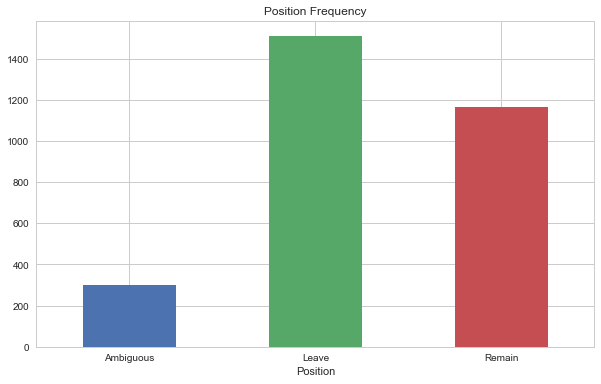

In [13]:
print(position_df.groupby('position').text_no_urls.count())
fig = plt.figure(figsize=(10,6))
position_df.groupby('position').text_no_urls.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Position Frequency')
plt.xlabel('Position')
plt.show()
#fig.savefig('Position Frequency.jpg', bbox_inches='tight')

Concatenate text, username, user screenname, and description fields, as position is indicated by all three. Use this as input for training the models (richer than just the tweet text features alone).

Performance is slightly worse if user_screen_name is used as opposed to user_name. Performance is slightly better or the same if both are used as opposed to only one.

In [14]:
position_df['text_username_description'] = position_df['text_no_urls'] + " " + position_df['user_name'] + " " + position_df['user_screen_name'] + " " + position_df['user_description'].fillna('')
position_df

C:\Users\Periwynkle\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,text_no_urls,position,user_name,user_screen_name,user_description,text_username_description
0,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE",Leave,#VoteLeaveEU,SAYNO2EU,Britain is STRONGER OUT of the EU #VoteLeave #BREXIT,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE #VoteLeaveEU SAYNO2EU Britain is STRONGER OUT of the EU #VoteLeave #BREXIT"
1,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Remain,Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain Ben Macpherson MSP BenMacpherson Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot."
2,We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people.,Leave,Stronger Out,confEUsedbrit,"Standing up for British people and British democracy. 323,000 immigrants per year + £350m paid to the EU per week + zero democracy = #voteleave","We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people. Stronger Out confEUsedbrit Standing up for British people and British democracy. 323,000 immigrants per year + £350m paid to the EU per week + zero democracy = #voteleave"
3,According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave,Leave,Scott Carlton,ScottPCarlton,NaN,According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave Scott Carlton ScottPCarlton
4,I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit,Remain,Enid The Cat,Enid_The_Cat,NaN,I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit Enid The Cat Enid_The_Cat
5,Misconceived EU is in terminal decline. Flawed antidemocratic design guarantees its death Best to #LEAVE before it destroys us too.,Leave,Latimer Alder,latimeralder,Sceptical about many things....,Misconceived EU is in terminal decline. Flawed antidemocratic design guarantees its death Best to #LEAVE before it destroys us too. Latimer Alder latimeralder Sceptical about many things....
6,Dave gives added reason to #Brexit and NOT #Bremain : demon israel needs EU @MnarMuh @PhilGreaves01,Leave,brian g,bodhibrian,"interested in buddhism, esp Dzogchen, like to travel. like to read, esp fantasy, scifi, mysticism and folklore. Fave film Avatar.","Dave gives added reason to #Brexit and NOT #Bremain : demon israel needs EU @MnarMuh @PhilGreaves01 brian g bodhibrian interested in buddhism, esp Dzogchen, like to travel. like to read, esp fantasy, scifi, mysticism and folklore. Fave film Avatar."
7,"Hey, #Remain - If we #VoteLeave, France, Germany, Spain, Portugal etc will still be there next day, and might even follow us out of the #EU",Leave,Mick Karma,MickKarma,"Musing and madness from the mind of a comedy anarchist & songwriter, and #Brexit supporter. Opinions are purely my own, not yours.","Hey, #Remain - If we #VoteLeave, France, Germany, Spain, Portugal etc will still be there next day, and might even follow us out of the #EU Mick Karma MickKarma Musing and madness from the mind of a comedy anarchist & songwriter, and #Brexit supporter. Opinions are purely my own, not yours."
8,"If you think we are #StrongerIn then you genuinely don't understand the concept of strengt

### Split the Data into Training/Test Sets

In [15]:
x = position_df['text_username_description']
y = position_df['position']
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y, position_df.index, test_size=0.1, random_state=0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print("Number of documents, number of features (counts):", X_train_counts.shape)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print("Number of documents, number of features (tf-idf scores):", X_train_tfidf.shape)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

f1_scorer = make_scorer(metrics.f1_score, average='weighted')
sample_texts = [position_df.loc[15].text_no_urls, position_df.loc[20].text_no_urls, position_df.loc[35].text_no_urls]

Number of documents, number of features (counts): (2678, 15965)
Number of documents, number of features (tf-idf scores): (2678, 15965)


## LINEAR CLASSIFIERS

For each classifier, build a pipeline and calculate 10-fold cross-validation and performance metrics.

### Naïve Bayes

In [8]:
clf_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

clf_nb = clf_nb.fit(X_train, y_train)
predicted_nb = clf_nb.predict(X_test)

print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_nb, average='weighted'))
nb_scores = cross_val_score(clf_nb, x, y, cv=10, scoring='f1_weighted')
print("10-fold CV F1 scores:", nb_scores)
print("Mean F1 score and 95%% CI: %0.2f (+/- %0.2f)" % (nb_scores.mean(), nb_scores.std()*2))
print(metrics.classification_report(y_test, predicted_nb))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mean F1 score (weighted): 0.6358117833179154


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

10-fold CV F1 scores: [0.62245931 0.57339043 0.64284641 0.59922659 0.59981818 0.56940966
 0.58461479 0.6168684  0.63988433 0.65663626]
Mean F1 score and 95% CI: 0.61 (+/- 0.06)


             precision    recall  f1-score   support

  Ambiguous       0.00      0.00      0.00        27
      Leave       0.65      0.97      0.78       160
     Remain       0.82      0.45      0.58       111

avg / total       0.66      0.69      0.64       298



C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Linear SVC Classifier

In [12]:
clf_svc = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                    ('clf-svc', LinearSVC(random_state=0))])

clf_svc = clf_svc.fit(X_train, y_train)
predicted_svc = clf_svc.predict(X_test)

print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc, average='weighted'))
svc_scores = cross_val_score(clf_svc, x, y, cv=10, scoring='f1_weighted')
print("10-fold CV F1 scores:", svc_scores)
print("Mean F1 score and 95%% CI: %0.2f (+/- %0.2f)" % (svc_scores.mean(), svc_scores.std()*2))
print(metrics.classification_report(y_test, predicted_svc))

Mean F1 score (weighted): 0.7845381358514848
10-fold CV F1 scores: [0.78571171 0.77436164 0.80652945 0.76361986 0.81778894 0.78357589
 0.77926509 0.81448432 0.8457178  0.77496451]
Mean F1 score and 95% CI: 0.79 (+/- 0.05)


             precision    recall  f1-score   support

  Ambiguous       0.70      0.26      0.38        27
      Leave       0.81      0.91      0.86       160
     Remain       0.79      0.77      0.78       111

avg / total       0.79      0.80      0.78       298



### Logistic Regression Classifier

In [14]:
clf_lr = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                   ('clf-lr', LogisticRegression(random_state=0))])

clf_lr = clf_lr.fit(X_train, y_train)
predicted_lr = clf_lr.predict(X_test)

print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_lr, average='weighted'))
lr_scores = cross_val_score(clf_lr, x, y, cv=10, scoring='f1_weighted')
print("10-fold CV F1 scores:", lr_scores)
print("Mean F1 score and 95%% CI: %0.2f (+/- %0.2f)" % (lr_scores.mean(), lr_scores.std()*2))
print(metrics.classification_report(y_test, predicted_lr))

Mean F1 score (weighted): 0.791148167700172
10-fold CV F1 scores: [0.77509415 0.75402931 0.77563764 0.77147715 0.78393297 0.77431861
 0.78776295 0.79898276 0.81560811 0.75827397]
Mean F1 score and 95% CI: 0.78 (+/- 0.03)


             precision    recall  f1-score   support

  Ambiguous       1.00      0.19      0.31        27
      Leave       0.81      0.94      0.87       160
     Remain       0.81      0.78      0.80       111

avg / total       0.83      0.81      0.79       298



### Grid Search

**Naïve Bayes Classifier**

In [17]:
clf_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

parameters_nb = {'vect__ngram_range': [(1, 1), (1, 2)], 
                 'vect__stop_words': (None, 'english'),
                 'vect__token_pattern': (r'(?u)\b\w\w+\b', r'\b[A-Za-z0-9]{3,}\b'),
                 'vect__min_df': (1, 2, 3),
                 'tfidf__sublinear_tf': (True, False), 
                 'tfidf__use_idf': (True, False), 
                 'clf__alpha': (1e-10, 0.1, 1)} 

gs_clf_nb = GridSearchCV(clf_nb, parameters_nb, return_train_score=True, cv=10, scoring=f1_scorer)

start_time = time.time()
gs_clf_nb = gs_clf_nb.fit(X_train, y_train)
print("Best mean F1 score:", gs_clf_nb.best_score_)
print("Best parameters:")
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, gs_clf_nb.best_params_[param_name]))    
end_time = time.time()
print("Total time:", end_time-start_time)

'''
Best mean F1 score: 0.7808885095063329
Best parameters:
clf__alpha: 0.1
tfidf__sublinear_tf: False
tfidf__use_idf: False
vect__min_df: 2
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
vect__token_pattern: '(?u)\\b\\w\\w+\\b'
Total time: 1089.2817549705505
'''

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Periwynkle\Anaconda3\lib\site-p

Best mean F1 score: 0.7808885095063329
Best parameters:
clf__alpha: 0.1
tfidf__sublinear_tf: False
tfidf__use_idf: False
vect__min_df: 2
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
vect__token_pattern: '(?u)\\b\\w\\w+\\b'
Total time: 1089.2817549705505


In [18]:
save_classifier = open('gs_clf_nb_position.pickle', 'wb') 
pickle.dump(gs_clf_nb, save_classifier)
save_classifier.close()

In [24]:
saved_classifier = open('gs_clf_nb_position.pickle', 'rb') 
gs_clf_nb = pickle.load(saved_classifier)
saved_classifier.close()

predicted_nb = gs_clf_nb.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_nb, average='weighted'))
print(metrics.classification_report(y_test, predicted_nb))

for text in sample_texts:
    print(text)
print("Predictions:", gs_clf_nb.predict(sample_texts))
print("Prediction probabilities:", '\n', gs_clf_nb.predict_proba(sample_texts))

conf_mat_nb = confusion_matrix(y_test, predicted_nb)
fig, ax = plt.subplots(figsize=(6,6))
conf_mat_nb_heatmap = sns.heatmap(conf_mat_nb, annot=True, fmt='d')
plt.title('Confusion Matrix for Best NB Position Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
fig = conf_mat_nb_heatmap.get_figure()
#fig.savefig('Confusion Matrix for Best NB Position Classifier.jpg', bbox_inches='tight')

**Linear SVC Classifier**

In [24]:
clf_svc = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                    ('clf-svc', LinearSVC(random_state=0))])

parameters_svc = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'vect__stop_words': (None, 'english'),
                  'vect__token_pattern': (r'(?u)\b\w\w+\b', r'\b[A-Za-z0-9]{3,}\b'),
                  'vect__min_df': (1, 2, 3),
                  'tfidf__sublinear_tf': (True, False), 
                  'tfidf__use_idf': (True, False),
                  'clf-svc__class_weight': (None, 'balanced')}

gs_clf_svc = GridSearchCV(clf_svc, parameters_svc, return_train_score=True, cv=10, scoring=f1_scorer)

start_time = time.time()
gs_clf_svc = gs_clf_svc.fit(X_train, y_train)
print("Best mean F1 score:", gs_clf_svc.best_score_)
print("Best parameters:")
for param_name in sorted(parameters_svc.keys()):
    print("%s: %r" % (param_name, gs_clf_svc.best_params_[param_name]))    
end_time = time.time()
print("Total time:", end_time-start_time)

'''
Best mean F1 score: 0.8175845511701262
Best parameters:
clf-svc__class_weight: 'balanced'
tfidf__sublinear_tf: True
tfidf__use_idf: True
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__stop_words: None
vect__token_pattern: '\\b[A-Za-z0-9]{3,}\\b'
Total time: 815.7075567245483
'''

Best mean F1 score: 0.8175845511701262
Best parameters:
clf-svc__class_weight: 'balanced'
tfidf__sublinear_tf: True
tfidf__use_idf: True
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__stop_words: None
vect__token_pattern: '\\b[A-Za-z0-9]{3,}\\b'
Total time: 815.7075567245483


"\nBest mean F1 score: 0.8175845511701262\nBest parameters:\nclf-svc__class_weight: 'balanced'\ntfidf__sublinear_tf: True\ntfidf__use_idf: True\nvect__min_df: 1\nvect__ngram_range: (1, 2)\nvect__stop_words: None\nvect__token_pattern: '\\b[A-Za-z0-9]{3,}\\b'\nTotal time: 820.9740884304047\n"

In [25]:
save_classifier = open('gs_clf_svc_position.pickle', 'wb') 
pickle.dump(gs_clf_svc, save_classifier)
save_classifier.close()

Mean F1 score (weighted): 0.8390498044287535
             precision    recall  f1-score   support

  Ambiguous       0.64      0.33      0.44        27
      Leave       0.86      0.93      0.89       160
     Remain       0.86      0.86      0.86       111

avg / total       0.84      0.85      0.84       298

If you love red tape, forms, no produtive jobs but huge expense accounts #VoteRemain
Mobile phone roaming charges cut within EU - BBC News #brexit #StrongerIn Check Swiss roaming charges.. ASTRONOMICAL 
#Remain for a successful, competitive future in the EU. 28 countries figuring it out together.  #Brexit wants the Empire back! #StrongerIn
Predictions: ['Remain' 'Remain' 'Remain']


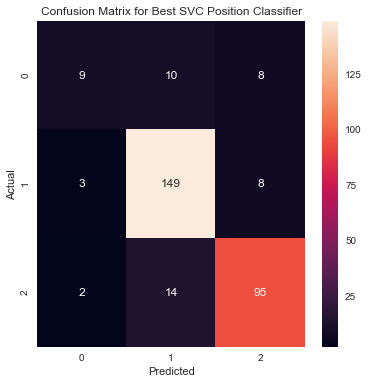

In [23]:
saved_classifier = open('gs_clf_svc_position.pickle', 'rb') 
gs_clf_svc = pickle.load(saved_classifier)
saved_classifier.close()

predicted_svc = gs_clf_svc.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc, average='weighted'))
print(metrics.classification_report(y_test, predicted_svc))

for text in sample_texts:
    print(text)
print("Predictions:", gs_clf_svc.predict(sample_texts))

conf_mat_svc = confusion_matrix(y_test, predicted_svc)
fig, ax = plt.subplots(figsize=(6,6))
conf_mat_svc_heatmap = sns.heatmap(conf_mat_svc, annot=True, fmt='d')
plt.title('Confusion Matrix for Best SVC Position Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
fig = conf_mat_svc_heatmap.get_figure()
#fig.savefig('Confusion Matrix for Best SVC Position Classifier.jpg', bbox_inches='tight')

**Logistic Regression Classifier**

In [30]:
clf_lr = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                   ('clf-lr', LogisticRegression(random_state=0))])

parameters_lr = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'vect__stop_words': (None, 'english'),
                 'vect__token_pattern': (r'(?u)\b\w\w+\b', r'\b[A-Za-z0-9]{3,}\b'),
                 'vect__min_df': (1, 2, 3),
                 'tfidf__sublinear_tf': (True, False), 
                 'tfidf__use_idf': (True, False),
                 'clf-lr__class_weight': (None, 'balanced')}

gs_clf_lr = GridSearchCV(clf_lr, parameters_lr, return_train_score=True, cv=10, scoring=f1_scorer)

start_time = time.time()
gs_clf_lr = gs_clf_lr.fit(X_train, y_train)
print("Best mean F1 score:", gs_clf_lr.best_score_)
print("Best parameters:")
for param_name in sorted(parameters_lr.keys()):
    print("%s: %r" % (param_name, gs_clf_lr.best_params_[param_name]))    
end_time = time.time()
print("Total time:", end_time-start_time)

'''
Best mean F1 score: 0.8177393230345786
Best parameters:
clf-lr__class_weight: 'balanced'
tfidf__sublinear_tf: True
tfidf__use_idf: True
vect__min_df: 2
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
vect__token_pattern: '(?u)\\b\\w\\w+\\b'
Total time: 795.966509103775
'''

Best mean F1 score: 0.8177393230345786
Best parameters:
clf-lr__class_weight: 'balanced'
tfidf__sublinear_tf: True
tfidf__use_idf: True
vect__min_df: 2
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
vect__token_pattern: '(?u)\\b\\w\\w+\\b'
Total time: 795.966509103775


In [31]:
save_classifier = open('gs_clf_lr_position.pickle', 'wb') 
pickle.dump(gs_clf_lr, save_classifier)
save_classifier.close()

In [26]:
saved_classifier = open('gs_clf_lr_position.pickle', 'rb') 
gs_clf_lr = pickle.load(saved_classifier)
saved_classifier.close()

predicted_lr = gs_clf_lr.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_lr, average='weighted'))
print(metrics.classification_report(y_test, predicted_lr))

for text in sample_texts:
    print(text)
print("Predictions:", gs_clf_lr.predict(sample_texts))
print("Prediction probabilities:", '\n', gs_clf_lr.predict_proba(sample_texts))

conf_mat_lr = confusion_matrix(y_test, predicted_lr)
fig, ax = plt.subplots(figsize=(6,6))
conf_mat_lr_heatmap = sns.heatmap(conf_mat_lr, annot=True, fmt='d')
plt.title('Confusion Matrix for Best LR Position Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
fig = conf_mat_lr_heatmap.get_figure()
#fig.savefig('Confusion Matrix for Best LR Position Classifier.jpg', bbox_inches='tight')

## COMBINE & COMPARE MODELS

### Voting Classifier

In [49]:
clf_ve = VotingClassifier(estimators=[('nb', gs_clf_nb.best_estimator_), 
                                      ('svc', gs_clf_svc.best_estimator_), 
                                      ('lr', gs_clf_lr.best_estimator_)], voting='hard')

clf_ve.fit(X_train, y_train)

Total time: 1.232560396194458


In [52]:
save_classifier = open('clf_ve_position.pickle', 'wb') 
pickle.dump(clf_ve, save_classifier)
save_classifier.close()

In [53]:
saved_classifier = open('clf_ve_position.pickle', 'rb') 
clf_ve = pickle.load(saved_classifier)
saved_classifier.close()

predicted_ve = clf_ve.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_ve, average='weighted'))
print(metrics.classification_report(y_test, predicted_ve))

for text in sample_texts:
    print(text)
print("Predictions:", clf_ve.predict(sample_texts))

conf_mat_ve = confusion_matrix(y_test, predicted_ve)
fig, ax = plt.subplots(figsize=(6,6))
conf_mat_ve_heatmap = sns.heatmap(conf_mat_ve, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Voting Ensemble Position Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
fig = conf_mat_ve_heatmap.get_figure()
#fig.savefig('Confusion Matrix for Best Voting Ensemble Position Classifier.jpg', bbox_inches='tight')

In [23]:
for predicted in position_df.position.unique():
    for actual in position_df.position.unique():
        if predicted != actual and conf_mat_ve[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(actual, predicted, conf_mat_ve[actual, predicted]))
            display(position_df.loc[indices_test[(y_test == actual) & (predicted_ve == predicted)]][['position', 'text_no_urls']])
            print('')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### 10-fold Cross-validation & Boxplot of Model Accuracies

In [57]:
models = [gs_clf_nb.best_estimator_, gs_clf_svc.best_estimator_, gs_clf_lr.best_estimator_, clf_ve]
names = ['Naïve Bayes', 'Linear SVC', 'Logistic Regression', 'Voting Ensemble']

cv_df = pd.DataFrame(index=range(10 * len(models)))
entries = []

for model, name in zip(models, names):
    model_name = name
    accuracies = cross_val_score(model, x, y, cv=10, scoring='f1_weighted')
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.to_csv("classifier_accuracies_position.csv")

Naïve Bayes
0 : 0.7480676665715725
1 : 0.7599789232940485
2 : 0.7568403727870393
3 : 0.7545080925451138
4 : 0.8053266259022476
5 : 0.7635902418586017
6 : 0.7782195324282866
7 : 0.807003489379529
8 : 0.803429405726564
9 : 0.7791016333487375
Linear SVC
0 : 0.8106518025909253
1 : 0.7933157856677768
2 : 0.807435234476163
3 : 0.7963949747877793
4 : 0.8369381203359136
5 : 0.8178107664793974
6 : 0.8284101769432275
7 : 0.8300495191478627
8 : 0.8614483201142211
9 : 0.816359994184262
Logistic Regression
0 : 0.7839261867934886
1 : 0.8021749106517125
2 : 0.8027613129960425
3 : 0.7993649594885323
4 : 0.8447038626742717
5 : 0.810254129970635
6 : 0.8113926146713032
7 : 0.8417160242668507
8 : 0.855915721567084
9 : 0.8120076440076441
Voting Ensemble


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

0 : 0.7974888013297091
1 : 0.8041675957304643
2 : 0.8183119776116365
3 : 0.7957798852199787
4 : 0.8399297256744446
5 : 0.8110502262078809
6 : 0.8220376794189395
7 : 0.8354236651129632
8 : 0.8559980286687262
9 : 0.8168254413000842
Total time: 27.300573348999023


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [108]:
fig, ax = plt.subplots(figsize=(10,6))
f1_boxplot = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.title('Boxplot of Classifier F1 Scores for Position')
plt.ylabel('Accuracy (F1 Score)')
plt.xlabel('Model')
plt.show()
fig = f1_boxplot.get_figure()
#fig.savefig('Boxplot of Classifier F1 Scores for Position.jpg', bbox_inches='tight')

print("Mean F1 Scores")
print(cv_df.groupby('model_name').accuracy.mean())
print("Standard Deviation")
print(cv_df.groupby('model_name').accuracy.std())
print("\n")
for clf, label in zip(models, names):
    scores = cross_val_score(clf, x, y, cv=10, scoring='f1_weighted')
    print("Accuracy (F1 Score): %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Mean F1 Scores
model_name
Linear SVC            0.82
Logistic Regression   0.82
Naïve Bayes           0.78
Voting Ensemble       0.82
Name: accuracy, dtype: float64
Standard Deviation
model_name
Linear SVC            0.02
Logistic Regression   0.02
Naïve Bayes           0.02
Voting Ensemble       0.02
Name: accuracy, dtype: float64


Accuracy (F1 Score): 0.78 (+/- 0.02) [Naïve Bayes]
Accuracy (F1 Score): 0.82 (+/- 0.02) [Linear SVC]
Accuracy (F1 Score): 0.82 (+/- 0.02) [Logistic Regression]


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

Accuracy (F1 Score): 0.82 (+/- 0.02) [Voting Ensemble]


C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Compute classification reports showing average accuracies from all ten folds for each classifier.

In [102]:
orig = []
pred = []

def cv_avg_classification_report(y_test, predicted_ve):
    orig.extend(y_test)
    pred.extend(predicted_ve)
    return metrics.f1_score(y_test, predicted_ve, average='weighted')

cross_val_score(clf_ve, x, y, cv=10, scoring=make_scorer(cv_avg_classification_report))
print(metrics.classification_report(orig, pred))

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

             precision    recall  f1-score   support

  Ambiguous       0.73      0.38      0.50       301
      Leave       0.86      0.89      0.87      1509
     Remain       0.80      0.87      0.83      1166

avg / total       0.82      0.83      0.82      2976



C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [105]:
orig = []
pred = []

def cv_avg_classification_report(y_test, predicted_svc):
    orig.extend(y_test)
    pred.extend(predicted_svc)
    return metrics.f1_score(y_test, predicted_svc, average='weighted')

cross_val_score(gs_clf_svc.best_estimator_, x, y, cv=10, scoring=make_scorer(cv_avg_classification_report))
print(metrics.classification_report(orig, pred))

             precision    recall  f1-score   support

  Ambiguous       0.76      0.39      0.52       301
      Leave       0.85      0.90      0.87      1509
     Remain       0.81      0.86      0.83      1166

avg / total       0.83      0.83      0.82      2976



In [109]:
orig = []
pred = []

def cv_avg_classification_report(y_test, predicted_lr):
    orig.extend(y_test)
    pred.extend(predicted_lr)
    return metrics.f1_score(y_test, predicted_lr, average='weighted')

cross_val_score(gs_clf_lr.best_estimator_, x, y, cv=10, scoring=make_scorer(cv_avg_classification_report))
print(metrics.classification_report(orig, pred))

             precision    recall  f1-score   support

  Ambiguous       0.72      0.40      0.52       301
      Leave       0.86      0.88      0.87      1509
     Remain       0.79      0.87      0.83      1166

avg / total       0.82      0.82      0.82      2976



In [119]:
orig = []
pred = []

def cv_avg_classification_report(y_test, predicted_nb):
    orig.extend(y_test)
    pred.extend(predicted_nb)
    return metrics.f1_score(y_test, predicted_nb, average='weighted')

cross_val_score(gs_clf_nb.best_estimator_, x, y, cv=10, scoring=make_scorer(cv_avg_classification_report))
print(metrics.classification_report(orig, pred))

             precision    recall  f1-score   support

  Ambiguous       0.78      0.23      0.35       301
      Leave       0.84      0.85      0.84      1509
     Remain       0.74      0.87      0.80      1166

avg / total       0.80      0.79      0.78      2976



Train the classifier with the highest accuracy on all of the labelled tweets in the random sample. SVC, LR, and the VE are extremely close; they have the same average F1 score and the same F1 scores for Leave and Remain. SVC is slightly better at predicting Ambiguous.

In [25]:
gs_clf_svc.best_estimator_.fit(x, y)
save_classifier = open('gs_clf_svc_position_trained.pickle', 'wb')
pickle.dump(gs_clf_svc.best_estimator_, save_classifier)
save_classifier.close()

Confirm that the classifier has been trained on all tweets.

In [26]:
saved_classifier = open('gs_clf_svc_position_trained.pickle', 'rb') 
gs_clf_svc_trained = pickle.load(saved_classifier)
saved_classifier.close()

In [27]:
predicted_svc_trained = gs_clf_svc_trained.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc_trained, average='weighted'))
print(metrics.classification_report(y_test, predicted_svc_trained))

Mean F1 score (weighted): 1.0
             precision    recall  f1-score   support

  Ambiguous       1.00      1.00      1.00        27
      Leave       1.00      1.00      1.00       160
     Remain       1.00      1.00      1.00       111

avg / total       1.00      1.00      1.00       298

